In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version

!pip install pyspark

update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java to provide /usr/bin/java (java) in manual mode
openjdk version "1.8.0_292"
OpenJDK Runtime Environment (build 1.8.0_292-8u292-b10-0ubuntu1~18.04-b10)
OpenJDK 64-Bit Server VM (build 25.292-b10, mixed mode)
     |████████████████████████████████| 212.4 MB 56 kB/s 
     |████████████████████████████████| 198 kB 53.5 MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=bddecc3639c7032d28dc38dca71a234d00de6482f376ba68c968b5c791a246c5
  Stored in directory: /root/.cache/pip/wheels/a5/0a/c1/9561f6fecb759579a7d863dcd846daaa95f598744e71b02c77
Successfully built pyspark


In [2]:
import requests
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark import SparkContext
from pyspark.sql import SparkSession
spark = SparkSession.Builder().appName("DataFrame Introduction").getOrCreate()
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import StringType
from io import StringIO

# **CRYPTINGUP üzerinden ASSETS ve MARKETS verilerinin alınması**

In [3]:
f_vrl = requests.get('https://www.cryptingup.com/api/assets?size=1000')

v = f_vrl.json()

varl = v['assets']

In [4]:
f_mrk = requests.get('https://www.cryptingup.com/api/assets/USD/markets?size=1000')

mrk = f_mrk.json()

mrkt = mrk['markets']

In [5]:
pd_vrl = pd.DataFrame(columns=["AssetId","Name","Price","Volume24h","Change1h","Change24h","Change7g","Status","CreatedAt","UpdatedAt"])
pd_vrl.head()

,AssetId,Name,Price,Volume24h,Change1h,Change24h,Change7g,Status,CreatedAt,UpdatedAt


In [6]:
df_mrk = pd.DataFrame(columns=["ExchangeId", "Symbol", "BaseAsset", "QuoteAsset", "PriceUnconverted", "Price", "Change24h", "Spread", "Volume24h", "Status", "CreatedAt", "UpdatedAt"])
df_mrk.head()

,ExchangeId,Symbol,BaseAsset,QuoteAsset,PriceUnconverted,Price,Change24h,Spread,Volume24h,Status,CreatedAt,UpdatedAt


# **ASSETS PD**

In [7]:
for i in range(0, len(varl)):
    currentItem=varl[i]
    pd_vrl.loc[i]=[varl[i]['asset_id'], varl[i]['name'], varl[i]['price'], varl[i]['volume_24h'], varl[i]['change_1h'], varl[i]['change_24h'], varl[i]['change_7d'], varl[i]['status'], varl[i]['created_at'], varl[i]['updated_at']]
pd_vrl.head(1000)

,AssetId,Name,Price,Volume24h,Change1h,Change24h,Change7g,Status,CreatedAt,UpdatedAt
0,USDT,Tether,0.999450,2.362444e+10,-0.061390,-0.084258,-0.168257,recent,2021-09-21T01:53:50,2021-10-15T06:09:40.107376
1,BTC,Bitcoin,59469.650306,1.008560e+10,-0.480420,2.602675,9.832869,recent,2021-09-21T01:27:16,2021-10-15T06:09:33.969614
2,ETH,Ethereum,3838.264815,6.188600e+09,0.240291,5.417045,7.127926,recent,2021-09-21T01:53:50,2021-10-15T06:09:35.239650
3,BUSD,Binance USD,0.998871,4.519983e+09,-0.150257,-0.112867,-0.177616,recent,2021-09-21T01:27:16,2021-10-15T06:09:34.088067
4,SHIB,,0.000027,1.742401e+09,-0.617631,-9.339252,14.736387,recent,2021-09-21T01:53:50,2021-10-15T06:09:39.060903
...,...,...,...,...,...,...,...,...,...,...
995,LIVE,,0.033270,2.404991e+02,-0.061405,11.356443,11.367619,recent,2021-09-21T01:53:50,2021-10-15T06:09:36.859395
996,LUCY,,0.006484,2.290139e+02,-0.801657,1.705060,8.872001,recent,2021-09-21T01:53:50,2021-10-15T06:09:37.010674
997,PBTC35A,,81.621415,2.220680e+02,-0.144256,-1.145034,13.978817,stale,2021-09-21T04:30:03,2021-10-13T07:55:35.615738
998,PUNK,,399503.677687,2.168226e+02,-1.669487,-4.856968,-22.385726,recent,2021-09-21T01:53:50,2021-10-15T06:09:38.473422


# **MARKETS PD**

In [8]:
for i in range(0, len(mrkt)):
    currentItem=mrkt[i]
    df_mrk.loc[i]=[mrkt[i]['exchange_id'], mrkt[i]['symbol'], mrkt[i]['base_asset'], mrkt[i]['quote_asset'], mrkt[i]['price_unconverted'], mrkt[i]['price'], mrkt[i]['change_24h'], mrkt[i]['spread'], mrkt[i]['volume_24h'], mrkt[i]['status'], mrkt[i]['created_at'], mrkt[i]['updated_at']]
df_mrk.head(1000)

,ExchangeId,Symbol,BaseAsset,QuoteAsset,PriceUnconverted,Price,Change24h,Spread,Volume24h,Status,CreatedAt,UpdatedAt
0,COINBASE,BTC-USD,BTC,USD,59444.780000,59444.780000,3.050975,0.001716,9.322874e+08,recent,2021-09-21T01:21:25,2021-10-15T06:10:28.781301
1,COINBASE,ETH-USD,ETH,USD,3837.565000,3837.565000,5.820366,0.014331,8.232376e+08,recent,2021-09-21T01:21:25,2021-10-15T06:10:32.656082
2,COINBASE,SHIB-USD,SHIB,USD,0.000026,0.000026,-9.034696,0.075500,4.443034e+08,recent,2021-09-21T01:21:25,2021-10-15T06:10:28.774522
3,BITFINEX,BTC-USD,BTC,USD,59494.500000,59494.500000,2.461896,0.018487,3.813096e+08,recent,2021-09-21T01:21:25,2021-10-15T06:10:32.206184
4,COINBASE,SOL-USD,SOL,USD,156.909500,156.909500,3.859239,0.027401,1.928565e+08,recent,2021-09-21T01:21:25,2021-10-15T06:10:32.653747
...,...,...,...,...,...,...,...,...,...,...,...,...
478,BITTREX,SLV-USD,SLV,USD,21.742000,21.742000,-0.128617,0.696672,1.578811e+01,recent,2021-09-21T01:21:25,2021-10-15T06:10:30.839636
479,BITFINEX,DCR-USD,DCR,USD,124.395000,124.395000,-0.872579,2.327983,1.243950e+01,recent,2021-09-21T01:21:25,2021-10-15T06:10:32.269093
480,BITTREX,FB-USD,FB,USD,328.799000,328.799000,1.557968,0.547767,6.651150e+00,stale,2021-09-21T01:21:25,2021-10-14T16:53:31.509379
481,BITTREX,SQ-USD,SQ,USD,239.941500,239.941500,0.094905,1.491247,4.955121e+00,stale,2021-09-21T01:21:25,2021-10-02T10:53:40.908216


In [9]:
pd_vrl["CreatedAt"] = pd_vrl["CreatedAt"].astype("datetime64")
pd_vrl["UpdatedAt"] = pd_vrl["UpdatedAt"].astype("datetime64")
df_mrk["CreatedAt"] = df_mrk["CreatedAt"].astype("datetime64")
df_mrk["UpdatedAt"] = df_mrk["UpdatedAt"].astype("datetime64")

In [10]:
pd_vrl.info()

df_mrk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   AssetId    1000 non-null   object        
 1   Name       1000 non-null   object        
 2   Price      1000 non-null   float64       
 3   Volume24h  1000 non-null   float64       
 4   Change1h   1000 non-null   float64       
 5   Change24h  1000 non-null   float64       
 6   Change7g   1000 non-null   float64       
 7   Status     1000 non-null   object        
 8   CreatedAt  1000 non-null   datetime64[ns]
 9   UpdatedAt  1000 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(5), object(3)
memory usage: 85.9+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 483 entries, 0 to 482
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ExchangeId        483 non-null    object

In [ ]:
#pd_vrl.to_excel("assets.xlsx")

In [ ]:
#df_mrk.to_excel("markets.xlsx")

In [11]:
sp_vrl_c=spark.createDataFrame(pd_vrl)

type(sp_vrl_c)

pyspark.sql.dataframe.DataFrame

In [12]:
df_mrk_sp=spark.createDataFrame(df_mrk)

type(df_mrk_sp)

pyspark.sql.dataframe.DataFrame

# **ASSETS SP**

In [13]:
sp_vrl_c.show()

+-------+-------------+-------------------+--------------------+--------------------+--------------------+--------------------+------+-------------------+--------------------+
|AssetId|         Name|              Price|           Volume24h|            Change1h|           Change24h|            Change7g|Status|          CreatedAt|           UpdatedAt|
+-------+-------------+-------------------+--------------------+--------------------+--------------------+--------------------+------+-------------------+--------------------+
|   USDT|       Tether| 0.9994500289629874|2.362443657242877E10|-0.06138953484434906|-0.08425786130384894| -0.1682567617442756|recent|2021-09-21 01:53:50|2021-10-15 06:09:...|
|    BTC|      Bitcoin|  59469.65030642628|1.008560053597274...| -0.4804197683578298|  2.6026748641235624|   9.832869286778276|recent|2021-09-21 01:27:16|2021-10-15 06:09:...|
|    ETH|     Ethereum| 3838.2648152658703| 6.188600115394828E9| 0.24029103135340107|   5.417044896215519|   7.127925502

# **MARKETS SP**

In [14]:
df_mrk_sp.show()

+----------+---------+---------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+------+-------------------+--------------------+
|ExchangeId|   Symbol|BaseAsset|QuoteAsset|    PriceUnconverted|               Price|           Change24h|              Spread|           Volume24h|Status|          CreatedAt|           UpdatedAt|
+----------+---------+---------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+------+-------------------+--------------------+
|  COINBASE|  BTC-USD|      BTC|       USD|            59444.78|            59444.78|   3.050975447097611|0.001715863443519...| 9.322873936114968E8|recent|2021-09-21 01:21:25|2021-10-15 06:10:...|
|  COINBASE|  ETH-USD|      ETH|       USD|            3837.565|            3837.565|   5.820366249458851|0.014330977841707363| 8.232375631665139E8|recent|2021-09-21 01:21:25|2021-10-15 06:10:...|
|  COINBASE| SH

# **Fiyat değişimi son 1 saat ve 24 saat içinde %10 oranında düşen varlıklar**

In [15]:
sp_vrl_c.createOrReplaceTempView("assets")

data_assets = spark.sql("select row_number() over(order by assetid) as sira,assetid,name,price,change1h,change24h,updatedat from assets where Change1h<=-10 or Change24h<=-10 order by assetid")

data_assets.show(1000)

+----+---------+--------------+--------------------+--------------------+-------------------+--------------------+
|sira|  assetid|          name|               price|            change1h|          change24h|           updatedat|
+----+---------+--------------+--------------------+--------------------+-------------------+--------------------+
|   1|1INCHDOWN|              | 0.02806268182695548| -0.6422793937997965|-15.589472608647881|2021-10-15 06:10:...|
|   2|    BCH3S|              |1.383238840084774...| 0.04704295390626562| -16.09017771847362|2021-10-15 06:09:...|
|   3|  BCHBEAR|              |1.175103371553232...| 0.16009994834996036|-16.458587811426543|2021-10-15 06:09:...|
|   4|  BCHDOWN|              |  0.2076357435170606| -0.1815080570380517|-12.691922484483179|2021-10-15 06:09:...|
|   5|      BEL|Bella Protocol|  2.7274231101649677| -1.6389324906124578|-16.099540671148045|2021-10-15 06:09:...|
|   6|      BNA|              | 0.00928988801921097| -11.277040661545184| -61.33

# **Son 24 saat içerisinde en fazla kazanan ve kaybeden varlık**

In [16]:
sp_vrl_c.createOrReplaceTempView("assets")

max_assets = spark.sql("select 'En çok kazanan'as comment,assetid,name,price,change24h,updatedat from assets where change24h = (select max(change24h) from assets)")

max_assets.show()

min_assets = spark.sql("select 'En çok kaybeden'as comment,assetid,name,price,change24h,updatedat from assets where change24h = (select min(change24h) from assets)")

min_assets.show()


+--------------+-------+----+-------------------+------------------+--------------------+
|       comment|assetid|name|              price|         change24h|           updatedat|
+--------------+-------+----+-------------------+------------------+--------------------+
|En çok kazanan|    GET|    |0.02857724200093123|2978.3990754579877|2021-10-15 06:09:...|
+--------------+-------+----+-------------------+------------------+--------------------+

+---------------+-------+----+-------------------+------------------+--------------------+
|        comment|assetid|name|              price|         change24h|           updatedat|
+---------------+-------+----+-------------------+------------------+--------------------+
|En çok kaybeden|    BNA|    |0.00928988801921097|-61.33568596256532|2021-10-15 06:09:...|
+---------------+-------+----+-------------------+------------------+--------------------+



# **1 Haftalık MARKETS veri yüklenmesi**

In [17]:
from google.colab import files
uploaded = files.upload()

Saving markets_5d.xlsx to markets_5d.xlsx


In [18]:
import io
data_market = pd.read_excel(io.BytesIO(uploaded['markets_5d.xlsx']))
data_market

,ExchangeId,Symbol,BaseAsset,QuoteAsset,PriceUnconverted,Price,Change24h,Spread,Volume24h,Status,CreatedAt,UpdatedAt
0,BITFINEX,NEC-USD,NEC,USD,0.079417,0.079417,0.429328,3.504757,44564.048303,stale,2021-09-21 01:21:25,2021-10-07 14:17:46
1,BITFINEX,RRB-USD,RRB,USD,1.000550,1.000550,0.024993,0.089910,628.392095,stale,2021-09-21 01:21:25,2021-10-07 14:17:46
2,BITFINEX,NEC-USD,NEC,USD,0.079417,0.079417,0.429328,3.504757,44564.048303,stale,2021-09-21 01:21:25,2021-10-07 14:17:46
3,BITFINEX,RRB-USD,RRB,USD,1.000550,1.000550,0.024993,0.089910,628.392095,stale,2021-09-21 01:21:25,2021-10-07 14:17:46
4,BITFINEX,NEC-USD,NEC,USD,0.079417,0.079417,0.429328,3.504757,44564.048303,stale,2021-09-21 01:21:25,2021-10-07 14:17:46
...,...,...,...,...,...,...,...,...,...,...,...,...
9627,KRAKEN,QTUM-USD,QTUM,USD,13.289950,13.289950,0.991606,0.084539,950986.664703,recent,2021-09-21 01:21:25,2021-10-15 17:45:33
9628,KRAKEN,MANA-USD,MANA,USD,0.779465,0.779465,3.576507,0.083356,475999.588486,recent,2021-09-21 01:21:25,2021-10-15 17:45:33
9629,KRAKEN,AUD-USD,AUD,USD,0.739655,0.739655,0.346629,0.036497,458629.680693,recent,2021-09-21 01:21:25,2021-10-15 17:45:33
9630,KRAKEN,ANT-USD,ANT,USD,4.614800,4.614800,3.156295,0.255373,211171.451729,recent,2021-09-21 01:21:25,2021-10-15 17:45:33


In [19]:
cb_btc=data_market[(data_market['ExchangeId']=="COINBASE")]
type(cb_btc)

pandas.core.frame.DataFrame

In [20]:
cb_btc_sp=spark.createDataFrame(cb_btc)
type(cb_btc_sp)

pyspark.sql.dataframe.DataFrame

# **COINBASE üzerinden takip edilen varlık bilgilerinin haftalık Max/Min değerleri**

In [21]:
cb_btc_sp.createOrReplaceTempView("coinbase")

data_coinbase = spark.sql("select exchangeid,symbol,baseasset,min(price) as min_price,max(price) as max_price from coinbase where baseasset in ('YFII','ETH','MKR','BCH', 'COMP') group by exchangeid,symbol,baseasset order by baseasset")

data_coinbase.show()


+----------+--------+---------+---------+---------+
|exchangeid|  symbol|baseasset|min_price|max_price|
+----------+--------+---------+---------+---------+
|  COINBASE| BCH-USD|      BCH|  572.725|   604.75|
|  COINBASE|COMP-USD|     COMP|  289.795|   318.85|
|  COINBASE| ETH-USD|      ETH| 3422.895| 3809.585|
|  COINBASE| MKR-USD|      MKR|2377.1244|2601.1091|
|  COINBASE|YFII-USD|     YFII|  3707.98|  4040.86|
+----------+--------+---------+---------+---------+



# **COINBASE üzerinden takip edilen varlık bilgilerinin haftalık grafik gösterimi**

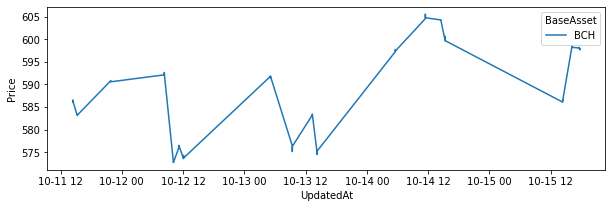

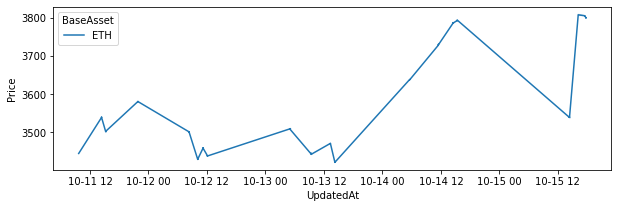

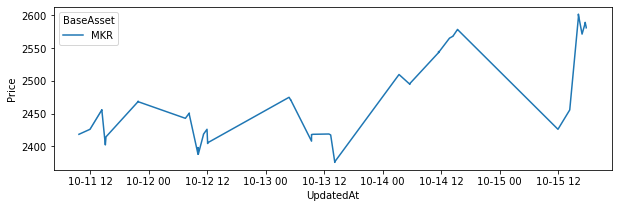

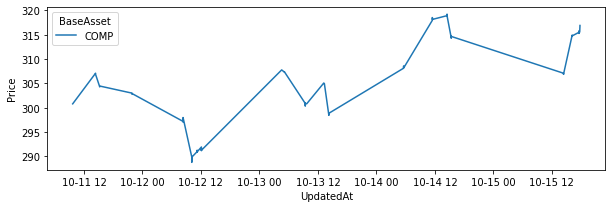

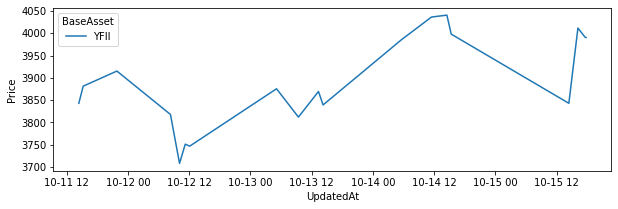

In [22]:
bch=data_market[(data_market['BaseAsset']=="BCH")]
eth=data_market[(data_market['BaseAsset']=="ETH")]
mkr=data_market[(data_market['BaseAsset']=="MKR")]
comp=data_market[(data_market['BaseAsset']=="COMP")]
yfii=data_market[(data_market['BaseAsset']=="YFII")]

plt.figure(figsize=(10,3))
sns.lineplot(data=bch, x="UpdatedAt",y="Price",hue='BaseAsset')
plt.show()
plt.figure(figsize=(10,3))
sns.lineplot(data=eth, x="UpdatedAt",y="Price",hue='BaseAsset')
plt.show()
plt.figure(figsize=(10,3))
sns.lineplot(data=mkr, x="UpdatedAt",y="Price",hue='BaseAsset')
plt.show()
plt.figure(figsize=(10,3))
sns.lineplot(data=comp, x="UpdatedAt",y="Price",hue='BaseAsset')
plt.show()
plt.figure(figsize=(10,3))
sns.lineplot(data=yfii, x="UpdatedAt",y="Price",hue='BaseAsset')
plt.show()


# **Anlık portföy değer bilgisi grafik gösterimi**

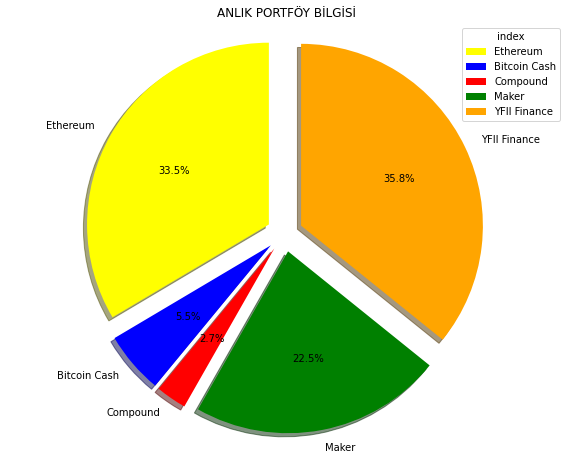

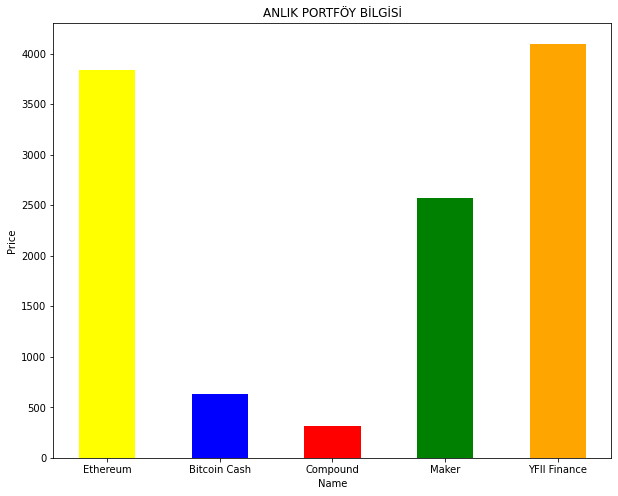

In [24]:
pd_vrl_c=pd_vrl[(pd_vrl["AssetId"] == "YFII") | (pd_vrl["AssetId"] == "ETH") | (pd_vrl["AssetId"] == "MKR") | (pd_vrl["AssetId"] == "BCH") | (pd_vrl["AssetId"] == "COMP")]


labels = pd_vrl_c.Name
sized = pd_vrl_c.Price
colors = ['yellow', 'blue', 'red', 'green', 'orange']
explode = (0.1, 0.1, 0.1, 0.1, 0.1)
plt.figure(figsize=(10, 8))
plt.pie(sized,labels=labels,explode=explode,autopct='%1.1f%%',colors=colors,shadow=True, startangle=90)
plt.axis('equal')
plt.legend(title='index', loc='upper right')
plt.title('ANLIK PORTFÖY BİLGİSİ')

x = pd_vrl_c.Name
y = pd_vrl_c.Price

plt.figure(figsize=(10, 8))
plt.bar(x,y,width=0.5,color=colors)
plt.title('ANLIK PORTFÖY BİLGİSİ')
plt.ylabel('Price')
plt.xlabel('Name')

plt.show()